# eBike Use Patterns: Exploratory Data Analysis
### by Cyrus Anderson

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>

## Introduction

The objective of this project was to wrangle, analyze, and visualize data from the Ford GoBike dataset, available on [Kaggle](https://www.kaggle.com/datasets/chirag02/ford-gobike-2019feb-tripdata), as a course requirement for the Udacity Data Analyst nanodegree program.

The Ford GoBike dataset contains trip and rider data for Ford GoBikes used in San Francisco during February of 2019. Data for >183,000 trips, including ride duration, the trip start and end time, trip start and end locations, rider gender, birth year, and customer status are available.

User information (age, member status) and trip information (ride start time, ride duration, and ride start and end location) are potentially useful for determining when and where peak use occurs, and building a description of likely users.

The current version of this project focuses on understanding peak use time and ride duration. Later versions of this project might evaluate use patterns by location to understand flow of inventory between stations.

<a id='wrangling'></a>

## Data Wrangling

### Import Libraries

In [1]:
# Import all packages and embed plots inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

%matplotlib inline

### Load and Assess Dataset

The version of the dataset used for this project is included in this repo as a csv file.

In [2]:
# Load DataFrame from manually downloaded csv
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# Overview of DataFrame and dtypes
print(df.shape)
print(df.info())

(183412, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  floa

### Data Cleaning

Data cleaning for this dataset includes:

*   removing null values
*   changing dtypes for convenient processing
*   adding variables for later analysis
*   removing outlier values

In [4]:
# Drop NaNs and incomplete data
df = df.dropna()

# Change station ids and birth years to 'int'
df['start_station_id'] = df['start_station_id'].astype('int')
df['end_station_id'] = df['end_station_id'].astype('int')
df['member_birth_year'] = df['member_birth_year'].astype('int')

# Change start and end date_string to datetime, conserve original date_strings
df['start_time_dt'] = pd.to_datetime(df['start_time'], format = '%Y-%m-%d %H:%M:%S.%f')
df['end_time_dt'] = pd.to_datetime(df['end_time'], format = '%Y-%m-%d %H:%M:%S.%f')

# Insert 'Day of Week' variable into DataFrame
df['day_of_week'] = df['start_time_dt'].apply(lambda x : x.strftime('%A'))

# Change day of week and gender strings to ordered category dtype
lstdow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
catdow = pd.CategoricalDtype(ordered = True, categories = lstdow)
df['day_of_week'] = df['day_of_week'].astype(catdow)

lstg = ['Male', 'Female', 'Other']
catg = pd.CategoricalDtype(ordered = True, categories = lstg)
df['member_gender'] = df['member_gender'].astype(catg)

# Calculate member age and insert as new variable
df['member_age'] = (2000 - df['member_birth_year']) + 19

# Drop member >90 years old (outliers)
df = df.query("member_age <= 90")

# Confirm changes
print(df.shape)
print(df.info())

(174875, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 174875 entries, 0 to 183411
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174875 non-null  int64         
 1   start_time               174875 non-null  object        
 2   end_time                 174875 non-null  object        
 3   start_station_id         174875 non-null  int64         
 4   start_station_name       174875 non-null  object        
 5   start_station_latitude   174875 non-null  float64       
 6   start_station_longitude  174875 non-null  float64       
 7   end_station_id           174875 non-null  int64         
 8   end_station_name         174875 non-null  object        
 9   end_station_latitude     174875 non-null  float64       
 10  end_station_longitude    174875 non-null  float64       
 11  bike_id                  174875 non-null  int64         
 12  user_typ

In [5]:
# Sample DataFrame
df

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,start_time_dt,end_time_dt,day_of_week,member_age
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984,Male,No,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,Thursday,35
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972,Male,No,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,Thursday,47
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375,Grove St at Masonic Ave,37.774836,-122.446546,70,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989,Other,No,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,Thursday,30
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7,Frank H Ogawa Plaza,37.804562,-122.271738,222,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974,Male,Yes,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,Thursday,45
5,1793,2019-02-28 23:49:58.6320,2019-03-01 00:19:51.7600,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,323,Broadway at Kearny,37.798014,-122.405950,5200,Subscriber,1959,Male,No,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,Thursday,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183407,480,2019-02-01 00:04:49.7240,2019-02-01 00:12:50.0340,27,Beale St at Harrison St,37.788059,-122.391865,324,Union Square (Powell St at Post St),37.788300,-122.408531,4832,Subscriber,1996,Male,No,2019-02-01 00:04:49.724,2019-02-01 00:12:50.034,Friday,23
183408,313,2019-02-01 00:05:34.7440,2019-02-01 00:10:48.5020,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,66,3rd St at Townsend St,37.778742,-122.392741,4960,Subscriber,1984,Male,No,2019-02-01 00:05:34.744,2019-02-01 00:10:48.502,Friday,35
183409,141,2019-02-01 00:06:05.5490,2019-02-01 00:08:27.2200,278,The Alameda at Bush St,37.331932,-121.904888,277,Morrison Ave at Julian St,37.333658,-121.908586,3824,Subscriber,1990,Male,Yes,2019-02-01 00:06:05.549,2019-02-01 00:08:27.220,Friday,29
183410,139,2019-02-01 00:05:34.3600,2019-02-01 00:07:54.2870,220,San Pablo Ave at MLK Jr Way,37.811351,-122.273422,216,San Pablo Ave at 27th St,37.817827,-122.275698,5095,Subscriber,1988,Male,No,2019-02-01 00:05:34.360,2019-02-01 00:07:54.287,Friday,31


In [6]:
# Check value counts for gender and user type
print(df['member_gender'].value_counts())
print(df['user_type'].value_counts())

member_gender
Male      130439
Female     40791
Other       3645
Name: count, dtype: int64
user_type
Subscriber    158315
Customer       16560
Name: count, dtype: int64


<a id='eda'></a>

## Exploratory Data Analysis

The following are preliminary assessments of the GoBike dataset aided by visualizations and feature engineering.

### Univariate Analysis

The following are evaluations of individual variables of interest in the dataset.

#### Ride Duration

How long is the typical GoBike ride?

Ride duration appears to have a normal distribution with a mean of 704s (11min 45s) and a median of 510s (8.5min).

Note: Ride duration is the amount of time between check-out and check-in. Duration does not necessarily represent the total time a bike was in motion or being actively ridden.

count    174875.000000
mean        704.028009
std        1642.537925
min          61.000000
25%         323.000000
50%         510.000000
75%         789.000000
max       84548.000000
Name: duration_sec, dtype: float64

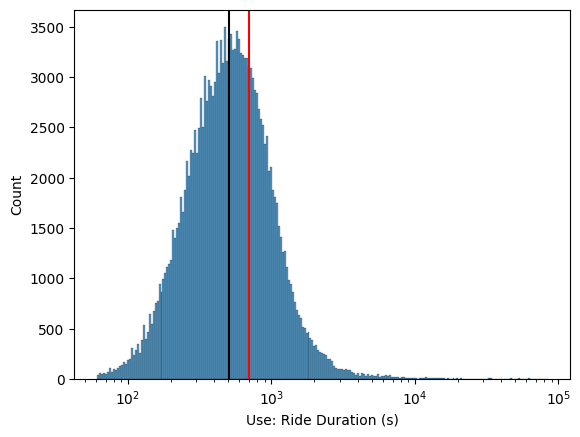

In [7]:
# Create a histogram of ride duration
ax = sns.histplot(data = df, x = 'duration_sec', log_scale = True);
plt.xlabel('Use: Ride Duration (s)')
ax.axvline(510, color = 'black')
ax.axvline(704, color = 'red');

# Determine mean and median of ride duration
df['duration_sec'].describe()

# Plotting time on a log scale gives a roughly normal distribution of trip duration 
# The mean ride duration is 704s (~11m 45s) as shown by the stats and red reference line
# The median ride duration is 510s (8m 30s) as shown by the stats and black reference line

#### Ride Start Time

What is/are peak times for GoBike use?

Because the average ride duration is 11m 45s, start times will be placed into 15m bins. At this point, the data will not be divided by day or week or other variable.

The ride start time distribution is multi-modal with peaks at the morning (08:45) and evening (17:30) commutes and a secondary peak over the lunch hour (12:45).

In [8]:
# Sort ride start times into 15 minute bins
# Define function to round datetime down to the nearest 15-minutes
# From Stephen Allwright: https://stephenallwright.com/python-round-time-15-minutes/#:~:text=Python%20round%20DateTime%20down%20to,floor%20instead%20of%20round%20.
def round_dt(dt, delta):
    return datetime.min + math.floor((dt - datetime.min) / delta) * delta
delta = timedelta(minutes = 15)

# Create dictionary of start times
dct = df['start_time'].to_dict()

# Convert date_strings to datetime, round to nearest 15 minutes, store time in dictionary
for k in dct:
    str_time = dct[k]
    dt = datetime.strptime(str_time, '%Y-%m-%d %H:%M:%S.%f')
    t = round_dt(dt, delta)
    dct[k] = t

# Create new DataFrame of rounded time data 'index' column for merging
df_time = pd.DataFrame.from_dict(dct, orient = 'index')
df_time = df_time.rename(columns = {0: 'time'})
idx = df_time.index.rename('index')
df_time['index'] = idx

# Create string representing time of day as hours:minutes
df_time['time_str'] = df_time['time'].apply(lambda x : x.strftime('%H:%M'))

# Create 'index' column in original DataFrame for merging
idx = df.index.rename('index')
df['index'] = idx

# Merge both DataFrames and drop unncessary columns
df = df.merge(df_time, how = 'left', left_on = 'index', right_on = 'index')
df = df.drop(columns = ['index', 'time'])

# Sample DataFrame
df

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,start_time_dt,end_time_dt,day_of_week,member_age,time_str
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13,Commercial St at Montgomery St,37.794231,...,4902,Customer,1984,Male,No,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,Thursday,35,17:30
1,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86,Market St at Dolores St,37.769305,-122.426826,3,Powell St BART Station (Market St at 4th St),37.786375,...,5905,Customer,1972,Male,No,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,Thursday,47,12:00
2,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375,Grove St at Masonic Ave,37.774836,-122.446546,70,Central Ave at Fell St,37.773311,...,6638,Subscriber,1989,Other,No,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,Thursday,30,17:45
3,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7,Frank H Ogawa Plaza,37.804562,-122.271738,222,10th Ave at E 15th St,37.792714,...,4898,Subscriber,1974,Male,Yes,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,Thursday,45,23:45
4,1793,2019-02-28 23:49:58.6320,2019-03-01 00:19:51.7600,93,4th St at Mission Bay Blvd S,37.770407,-122.391198,323,Broadway at Kearny,37.798014,...,5200,Subscriber,1959,Male,No,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,Thursday,60,23:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174870,480,2019-02-01 00:04:49.7240,2019-02-01 00:12:50.0340,27,Beale St at Harrison St,37.788059,-122.391865,324,Union Square (Powell St at Post St),37.788300,...,4832,Subscriber,1996,Male,No,2019-02-01 00:04:49.724,2019-02-01 00:12:50.034,Friday,23,00:00
174871,313,2019-02-01 00:05:34.7440,2019-02-01 00:10:48.5020,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,66,3rd St at Townsend St,37.778742,...,4960,Subscriber,1984,Male,No,2019-02-01 00:05:34.744,2019-02-01 00:10:48.502,Friday,35,00:00
174872,141,2019-02-01 00:06:05.5490,2019-02-01 00:08:27.2200,278,The Alameda at Bush St,37.331932,-121.904888,277,Morrison Ave at Julian St,37.333658,...,3824,Subscriber,1990,Male,Yes,2019-02-01 00:06:05.549,2019-02-01 00:08:27.220,Friday,29,00:00
174873,139,2019-02-01 00:05:34.3600,2019-02-01 00:07:54.2870,220,San Pablo Ave at MLK Jr Way,37.811351,-122.273422,216,San Pablo Ave at 27th St,37.817827,...,5095,Subscriber,1988,Male,No,2019-02-01 00:05:34.360,2019-02-01 00:07:54.287,Friday,31,00:00


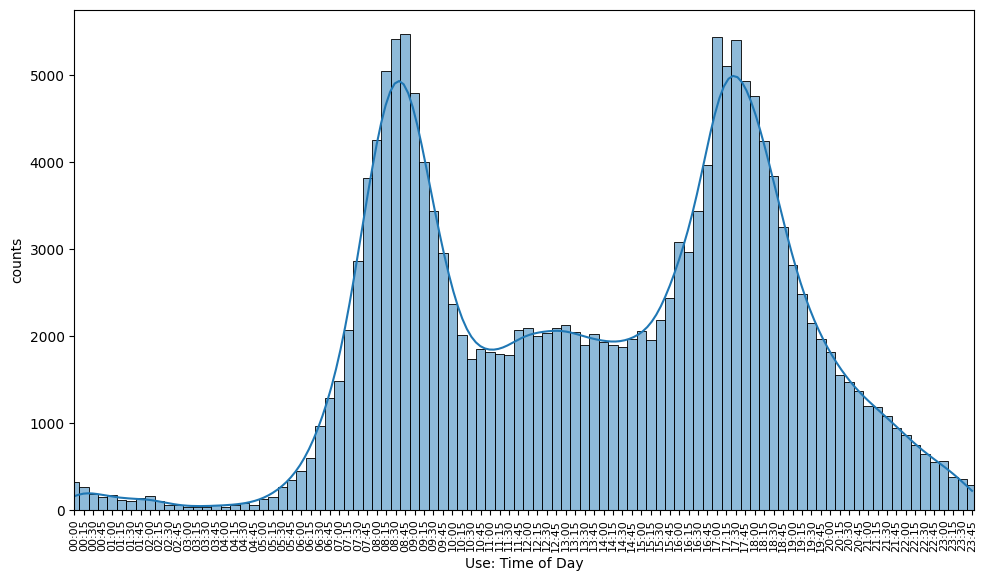

In [9]:
# Sort time data for plotting
plot_df = df[['time_str']]
plot_df = plot_df.sort_values(by = 'time_str')

# Plot histrogram of time start data
fig = plt.figure(figsize = (9, 5))
ax = fig.add_axes((1, 1, 1, 1));
ax = sns.histplot(data = plot_df, x = 'time_str', kde = True)
plt.xticks(rotation = 90)
ax.set_xlim(left = 0, right = 95.25)
ax.tick_params(axis = 'x', labelsize = 8)
ax.set_xlabel('Use: Time of Day')
ax.set_ylabel('counts');

# The ride start time distribution is multi-modal with peaks at the morning and evening commute 
# and a small peak over the lunch hour

#### Ride Day of Week

Which day of the week are GoBikes used the most?

Weekday use is more common than weekends with Thursday being the most frequent day for use.

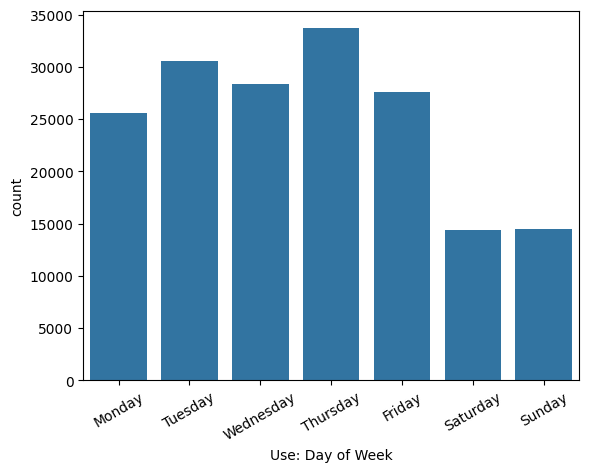

In [10]:
# Create histogram of rides by day of week
sns.countplot(data = df, x = 'day_of_week', color = 'tab:blue')
plt.xticks(rotation = 30)
plt.xlabel('Use: Day of Week');

# Weekday use is more common than weekends
# Thursday is the most frequent day for use

#### Rider Age Distribution

What age is the typical rider?

The rider age distribution is right skewed with a mean of 34 and a median of 32. 75% of riders are under age 39.

Note: Outliers at 90 - 140 yrs old were removed during data cleaning. These were probably typos or intenionally misleading user data.

count    174875.000000
mean         34.160274
std           9.968641
min          18.000000
25%          27.000000
50%          32.000000
75%          39.000000
max          89.000000
Name: member_age, dtype: float64

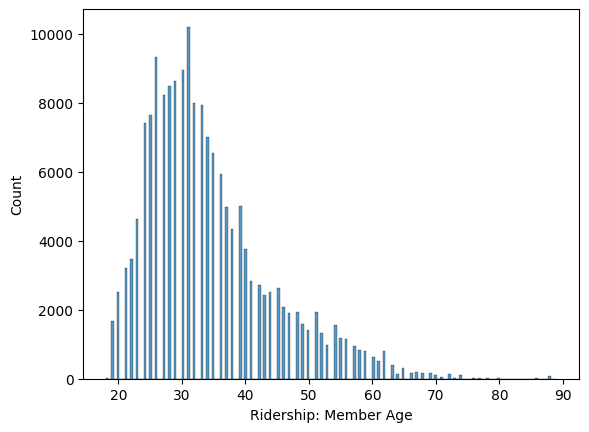

In [11]:
# Create a histogram of rider age
sns.histplot(data = df, x = 'member_age')
plt.xlabel('Ridership: Member Age');

# Determine mean and median of rider age
df['member_age'].describe()

# The rider age distribution is right skewed with a mean of 34 and a median of 32

#### Rider Gender Distribution

Which genders make the most GoBike rides?

Males are more than 3x more likely to make go bike trips than females.

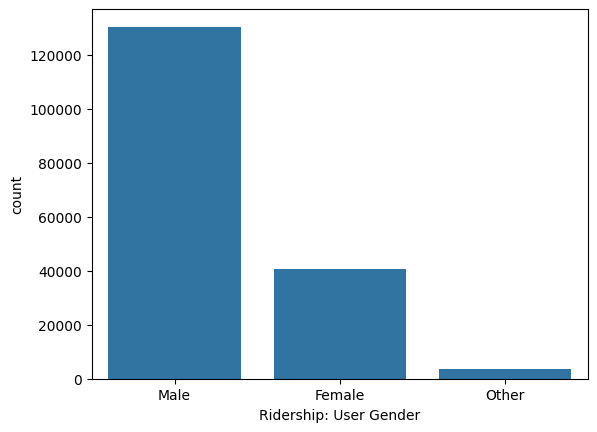

In [12]:
# Create a histogram of rides by gender
sns.countplot(data = df, x = 'member_gender', color = 'tab:blue')
plt.xlabel('Ridership: User Gender');

#### Rider User Type 

Which user type makes the most GoBike rides?

Subscribers are >7x more likely to make trips than non-subscribers.

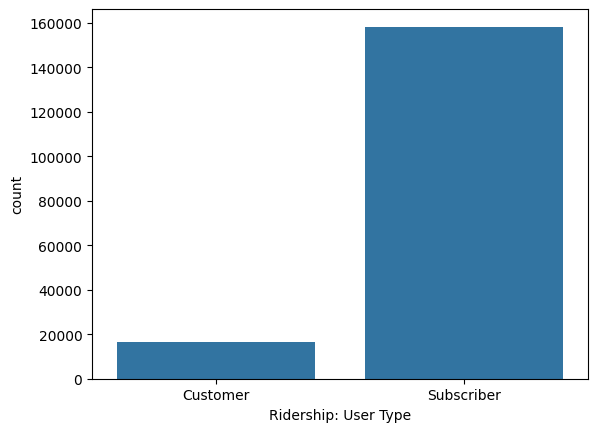

In [13]:
# Create a histogram of rides by user type
sns.countplot(data = df, x = 'user_type', color = 'tab:blue')
plt.xlabel('Ridership: User Type');

#### Univariate Analysis: Preliminary Observations

Univariate analysis led to the following observations:

*   Ride Duration: Rides were typically short, less than 15 minutes
*   Ride Start Time: If GoBikes are used primarily for commuting, the time-of-day use pattern makes sense
*   Ride Day of Week: If GoBikes are used primarily for commuting, the weekday use pattern also makes sense
*   Rider Age: 75% of riders are under age 39; this is not suprising based on general fitness
*   Rider Gender: Male was the most common user gender
*   Rider Member Status: Subscriber was the most common user class

### Bivariate Analysis

The following are evaluations of pairs of variables in the dataset.

#### Age vs Ride Duration

Does ride duration vary by rider age?

A ride duration of ~510s (reference line) is typical for 20 - 60 year olds with a maxiumum variability for 30 year olds ranging from 100 - 1100s.

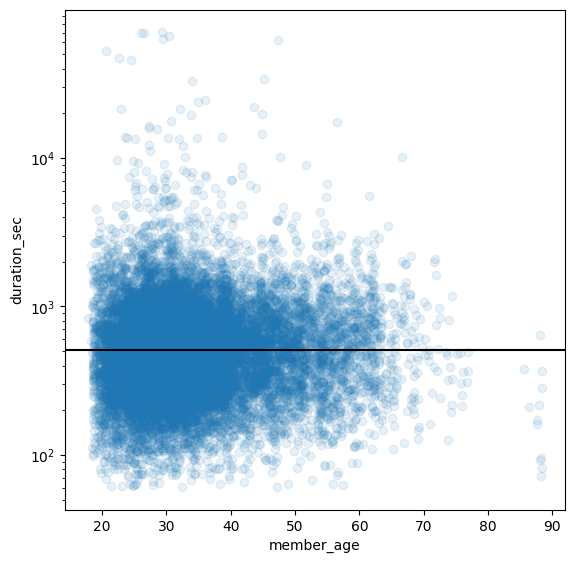

In [14]:
# Create scatter plot of ride duration vs rider age
# Prevent overplotting by sampling from the dataset 
fig = plt.figure(figsize = (5, 5))
ax = fig.add_axes((1, 1, 1, 1));
ax = sns.regplot(data = df.sample(frac = 0.1, replace = False, random_state = 9), x = 'member_age', y = 'duration_sec', scatter = True,
                 fit_reg = False, ci = None, x_jitter = 0.5, scatter_kws = {'alpha' : 0.1})
ax.set_yscale('log')
ax.axhline(510, color = 'black');

# Reference line at 510s represents the median of the ride duration data for all ages
# I may change this to a regplot in the future and determine a line of best fit

#### Gender vs Ride Duration

Does ride duration vary by gender?

The mean ride duration for males is slightly less than that for females and other.

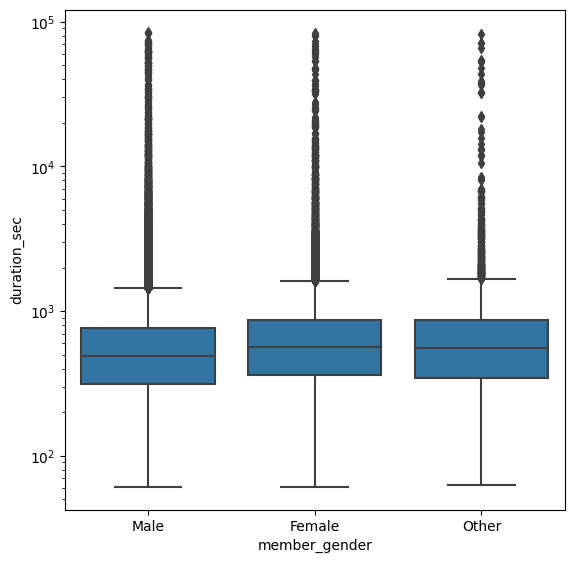

In [15]:
# Create boxplot of ride duraiton by gender
fig = plt.figure(figsize = (5, 5))
ax = fig.add_axes((1, 1, 1, 1));
ax = sns.boxplot(data = df, x = 'member_gender', y = 'duration_sec', color = 'tab:blue')
ax.set_yscale('log');

# The median ride duration for males is slightly less than that for females and other

#### Gender vs Day of Week

Does the number of rides for each gender vary by day of week?

Each gender has the same day of week riding behavior.

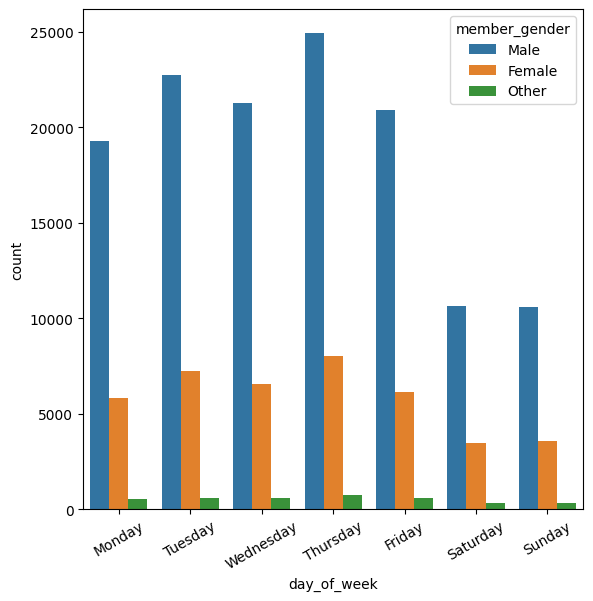

In [16]:
# Create clustered bar chart of rides by gender and day of week
fig = plt.figure(figsize = (5, 5))
ax = fig.add_axes((1, 1, 1, 1));
ax = sns.countplot(data = df, x = 'day_of_week', hue = 'member_gender')
plt.xticks(rotation = 30);

# Each gender has the same day of week riding behavior

#### Day of Week vs Ride Duration

Does the ride duration vary by day of week?

The mean ride time on weekends is slightly longer than weekdays, but is also more variable.

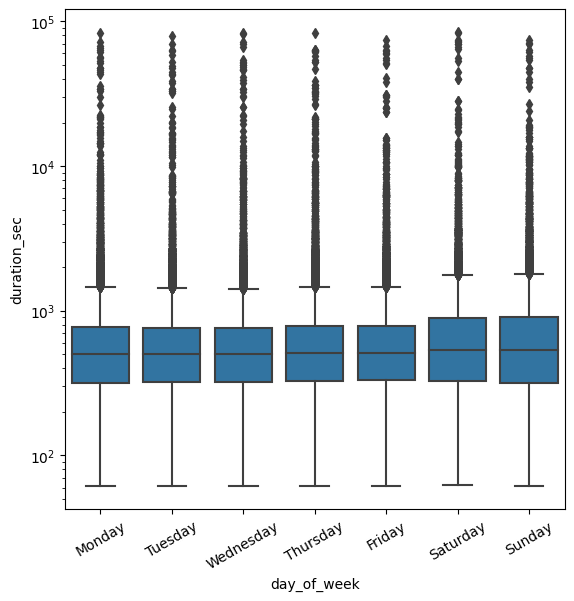

In [17]:
# Create boxplot of ride duration by day of week
fig = plt.figure(figsize = (5, 5))
ax = fig.add_axes((1, 1, 1, 1));
ax = sns.boxplot(data = df, x = 'day_of_week', y = 'duration_sec', color = 'tab:blue')
ax.set_yscale('log')
plt.xticks(rotation = 30);

# The median ride time on weekends is slightly longer than weekdays
# but is also more variable.

#### Day of Week vs Ride Start Time

Does ride start time vary by day of week?

Observations:
*   The weekday ride start time distribution is different than the weekend ride start time distribution. 
*   Weekday rides appear to start at typical commute times for the workday. 
*   Weekend rides appear to start later and more uniformly throughout the day.

In [18]:
# Prepare DataFrame for violin plot
plot_df = df[['day_of_week', 'time_str', 'duration_sec', 'member_age', 'member_gender']]
plot_df = plot_df.sort_values(by = 'time_str')

# Map time_string to integer for plotting on x-axis of violin plot
x = plot_df['time_str'].value_counts().index.sort_values().to_list()
interval = pd.DataFrame({'time' : x})
interval = interval.reset_index(names = ['interval'])

# Merge mapped integer to plotting DataFrame, drop unnecessary columns
plot_df = plot_df.merge(interval, how = 'left', left_on = 'time_str', right_on = 'time')
plot_df = plot_df.drop(columns = ['time'])

# Sample DataFrame for violin plot
plot_df

,day_of_week,time_str,duration_sec,member_age,member_gender,interval
0,Friday,00:00,271,30,Male,0
1,Saturday,00:00,502,19,Male,0
2,Saturday,00:00,735,19,Male,0
3,Saturday,00:00,1169,37,Male,0
4,Thursday,00:00,67,24,Male,0
...,...,...,...,...,...,...
174870,Thursday,23:45,302,24,Male,95
174871,Thursday,23:45,330,37,Male,95
174872,Friday,23:45,826,22,Other,95
174873,Thursday,23:45,164,60,Male,95


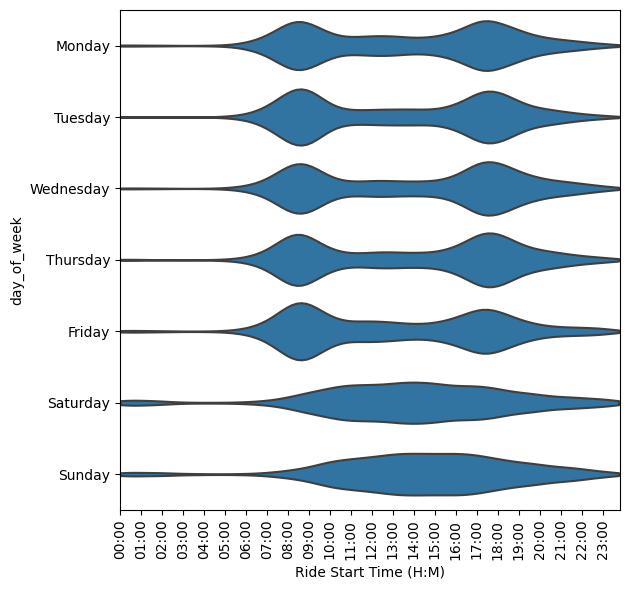

In [19]:
# Create Violin Plot of Ride Start Time vs Day of Week
fig = plt.figure(figsize = (5, 5))
ax = fig.add_axes((1, 1, 1, 1));
ax = sns.violinplot(data = plot_df, x = 'interval', y = 'day_of_week', inner = None, cut = 0, color = 'tab:blue')
ax.set_xticks(np.arange(0, 96, 4), ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
                                   '07:00', '08:00', '09:00', '10:00', '11:00', '12:00',
                                   '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', 
                                    '19:00', '20:00', '21:00', '22:00', '23:00'])
ax.set_xlim(left = 0, right = 95.25)
plt.xticks(rotation = 90)
plt.xlabel('Ride Start Time (H:M)');

# The weekday ride start time distribution is different than the weekend ride start time distribution.
# Weekday rides appear to start at typical commute times for the workday.
# Weekend rides appear to start later and more uniformly throughout the day.

#### Bivariate Analysis: Preliminary Observations

Bivariate analysis led to the following observations:

*   Age vs Duration: The typical ride duration was ~10 minutes. There was substantial variability in ride duration vs age with 30 year olds having the largest range (2 - 20 minutes). Variability decreased with age.
*   Duration vs Gender: The mean ride duration for males was slightly less than that for other genders. There was substantial overlap of the IQR so this difference might not be practically relevant.
*   Gender vs Day of Week: The number of rides by day of week for each gender had the same pattern. Weekdays saw the highest amount of use and weekends the least.
*   Day of Week vs Duration: Weekday ride durations are consistent Monday - Friday. Weekend (Saturday and Sunday) ride durations are slightly longer and have greater variability.
*   Day of Week vs Ride Start Time: Weekday start times follow the same pattern each day Monday - Friday with peak use at the morning and evening commute times. Weekends (Saturday and Sunday) have a different use pattern that starts later and is more uniform throughout the day.

### Multivariate Exploration

The following are evaluations of multiple variables in the dataset.

#### Ride Start Time vs Day of Week vs Ride Duration

Does ride start time and duration vary by day of week? If weekend rides are longer than weekday rides and if weekend rides start at different times than weekdays, is there a day or time riders typically start long rides?

Observations:
*   Longer rides typically started between 10am-6pm
*   Longer rides were more frequent on weekends than on weekdays
*   The longest rides occured on weekends

In [20]:
# Create working copy of df
mvar_plot_df = plot_df.copy()

# Prepare DataFrame for multivariate visualization by adding ride duration category
dur = mvar_plot_df[['duration_sec']]

dur1 = dur.query("duration_sec < 300")
dur1 = dur1.assign(ride_duration = 'Short')

dur2 = dur.query("300 <= duration_sec <= 1100")
dur2 = dur2.assign(ride_duration = 'Medium')

dur3 = dur.query("duration_sec > 1100")
dur3 = dur3.assign(ride_duration = 'Long')

# Concatenate the DataFrames, set category order
cmb_df = pd.concat([dur1, dur2, dur3])
cmb_df = cmb_df.drop(columns = 'duration_sec')
lst = ['Short', 'Medium', 'Long']
durcat = pd.CategoricalDtype(ordered = True, categories = lst)
cmb_df['ride_duration'] = cmb_df['ride_duration'].astype(durcat)

# Sample DataFrame of ride duration and ride duration categories
cmb_df

# Plotting this by ride duration proved cumbersome and was abandoned in the current version of the project

,ride_duration
0,Short
4,Short
7,Short
12,Short
13,Short
...,...
174840,Long
174843,Long
174856,Long
174866,Long


In [21]:
# Merge with plotting DataFrame
mvar_plot_df = mvar_plot_df.merge(cmb_df, how = 'left', left_index = True, right_index = True)

# Sample DataFrame
mvar_plot_df

,day_of_week,time_str,duration_sec,member_age,member_gender,interval,ride_duration
0,Friday,00:00,271,30,Male,0,Short
1,Saturday,00:00,502,19,Male,0,Medium
2,Saturday,00:00,735,19,Male,0,Medium
3,Saturday,00:00,1169,37,Male,0,Long
4,Thursday,00:00,67,24,Male,0,Short
...,...,...,...,...,...,...,...
174870,Thursday,23:45,302,24,Male,95,Medium
174871,Thursday,23:45,330,37,Male,95,Medium
174872,Friday,23:45,826,22,Other,95,Medium
174873,Thursday,23:45,164,60,Male,95,Short


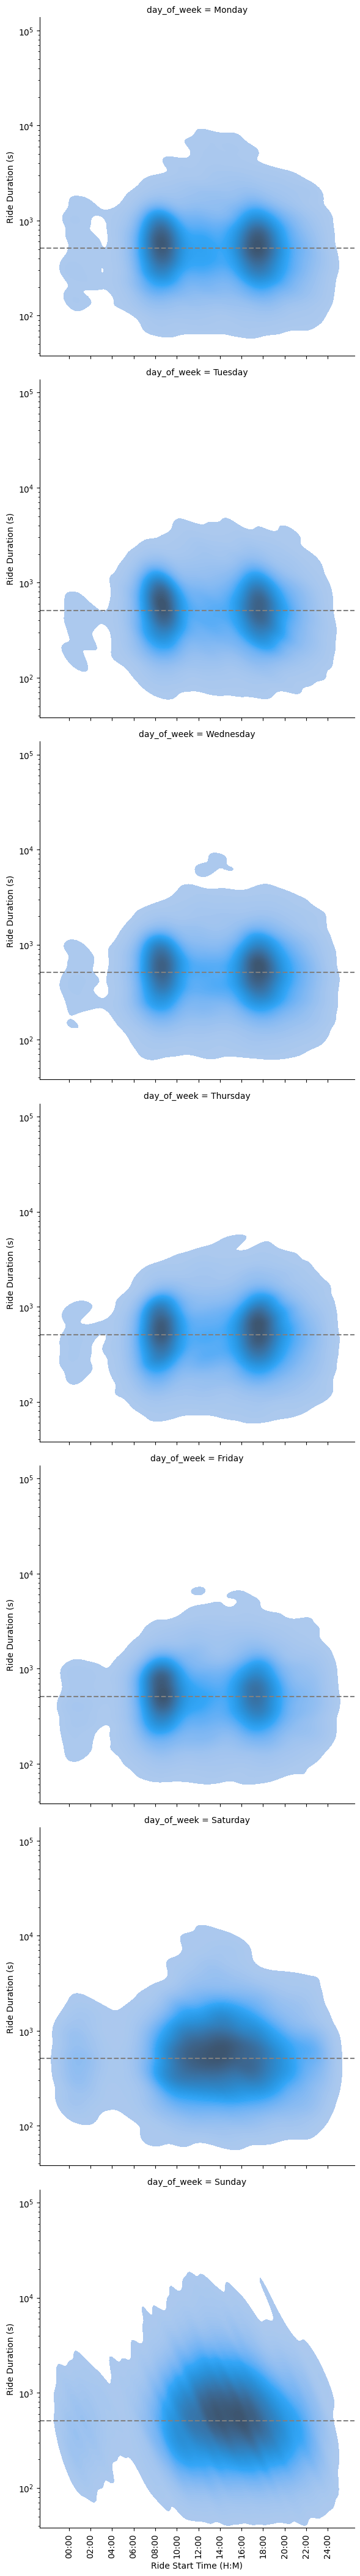

In [24]:
# Set x ticks for plot
xt = np.arange(0, 97, 8)

# Create FacetGrid of Ride Start Time vs Duration vs Day of Week
g = sns.FacetGrid(data = mvar_plot_df, row = 'day_of_week', height = 6, aspect = 1)
g.map_dataframe(sns.kdeplot, x = 'interval', y = 'duration_sec', 
                 log_scale = (False, True), levels = 100, thresh = 0.01, fill = True)
g.set_axis_labels('Ride Start Time (H:M)', 'Ride Duration (s)')
g.set(xticks = xt)
g.refline(y = 510)
g.set_xticklabels(['00:00', '02:00', '04:00', '06:00', '08:00', '10:00', '12:00', '14:00', '16:00', '18:00', '20:00', '22:00', '24:00'], rotation = 90);

#### Age vs Ride Start Time vs Day of Week vs Ride Duration

Does ride duration vary by rider age, start time, and day of week? Do riders of different age groups start rides at different times depending on the day of week?

To answer these questions, member ages will be grouped and day of week will be categorized as weekday or weekend.

Observations:
*   Ride duration was fairly consistent regardless of age, day of week, and start time
*   Looking at the variability, 21 - 40 year olds typically took the longest rides
*   21 - 40 year olds took more 'late-night' rides between midnight and 2am

In [22]:
# Prepare DataFrame for multivariate visualization by adding member age category
age_df = mvar_plot_df[['member_age']]

a1 = age_df.query("member_age <= 20")
a1 = a1.assign(age_category = '<21')

a2 = age_df.query("20 < member_age <= 30")
a2 = a2.assign(age_category = '21-30')

a3 = age_df.query("30 < member_age <= 40")
a3 = a3.assign(age_category = '31-40')

a4 = age_df.query("40 < member_age <= 50")
a4 = a4.assign(age_category = '41-50')

a5 = age_df.query("50 < member_age <= 60")
a5 = a5.assign(age_category = '51-60')

a6 = age_df.query("60 < member_age <= 70")
a6 = a6.assign(age_category = '61-70')

a7 = age_df.query("70 < member_age <= 80")
a7 = a7.assign(age_category = '71-80')

a8 = age_df.query("80 < member_age")
a8 = a8.assign(age_category = '80+')

# Concatenate DataFrames, set categorical order
cmb_df = pd.concat([a1, a2, a3, a4, a5, a6, a7, a8])
cmb_df = cmb_df.drop(columns = 'member_age')
lst = ['<21', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']
agecat = pd.CategoricalDtype(ordered = True, categories = lst)
cmb_df['age_category'] = cmb_df['age_category'].astype(agecat)

# Prepare weekday/weekend category
dow_df = mvar_plot_df[['day_of_week']]

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']

wd = dow_df.query("day_of_week == @weekdays")
wd = wd.assign(weekday_or_weekend = 'Weekday')

we = dow_df.query("day_of_week == @weekends")
we = we.assign(weekday_or_weekend = 'Weekend')

# Concatenate DataFrames, set categorical order
wd_we_df = pd.concat([wd, we])
wd_we_df = wd_we_df.drop(columns = 'day_of_week')
lst = ['Weekday', 'Weekend']
wd_we_cat = pd.CategoricalDtype(ordered = True, categories = lst)
wd_we_df['weekday_or_weekend'] = wd_we_df['weekday_or_weekend'].astype(wd_we_cat)

# Merge categorical assignments DataFrames
cmb_df = cmb_df.merge(wd_we_df, how = 'left', left_index = True, right_index = True)

# Sample DataFrame
cmb_df

,age_category,weekday_or_weekend
1,<21,Weekend
2,<21,Weekend
18,<21,Weekend
31,<21,Weekend
59,<21,Weekend
...,...,...
125562,80+,Weekday
132503,80+,Weekday
139497,80+,Weekday
142500,80+,Weekday


In [23]:
# Merge with plotting DataFrame
mvar_plot_df = mvar_plot_df.merge(cmb_df, how = 'left', left_index = True, right_index = True)

# Sample DataFrame
mvar_plot_df

,day_of_week,time_str,duration_sec,member_age,member_gender,interval,ride_duration,age_category,weekday_or_weekend
0,Friday,00:00,271,30,Male,0,Short,21-30,Weekday
1,Saturday,00:00,502,19,Male,0,Medium,<21,Weekend
2,Saturday,00:00,735,19,Male,0,Medium,<21,Weekend
3,Saturday,00:00,1169,37,Male,0,Long,31-40,Weekend
4,Thursday,00:00,67,24,Male,0,Short,21-30,Weekday
...,...,...,...,...,...,...,...,...,...
174870,Thursday,23:45,302,24,Male,95,Medium,21-30,Weekday
174871,Thursday,23:45,330,37,Male,95,Medium,31-40,Weekday
174872,Friday,23:45,826,22,Other,95,Medium,21-30,Weekday
174873,Thursday,23:45,164,60,Male,95,Short,51-60,Weekday


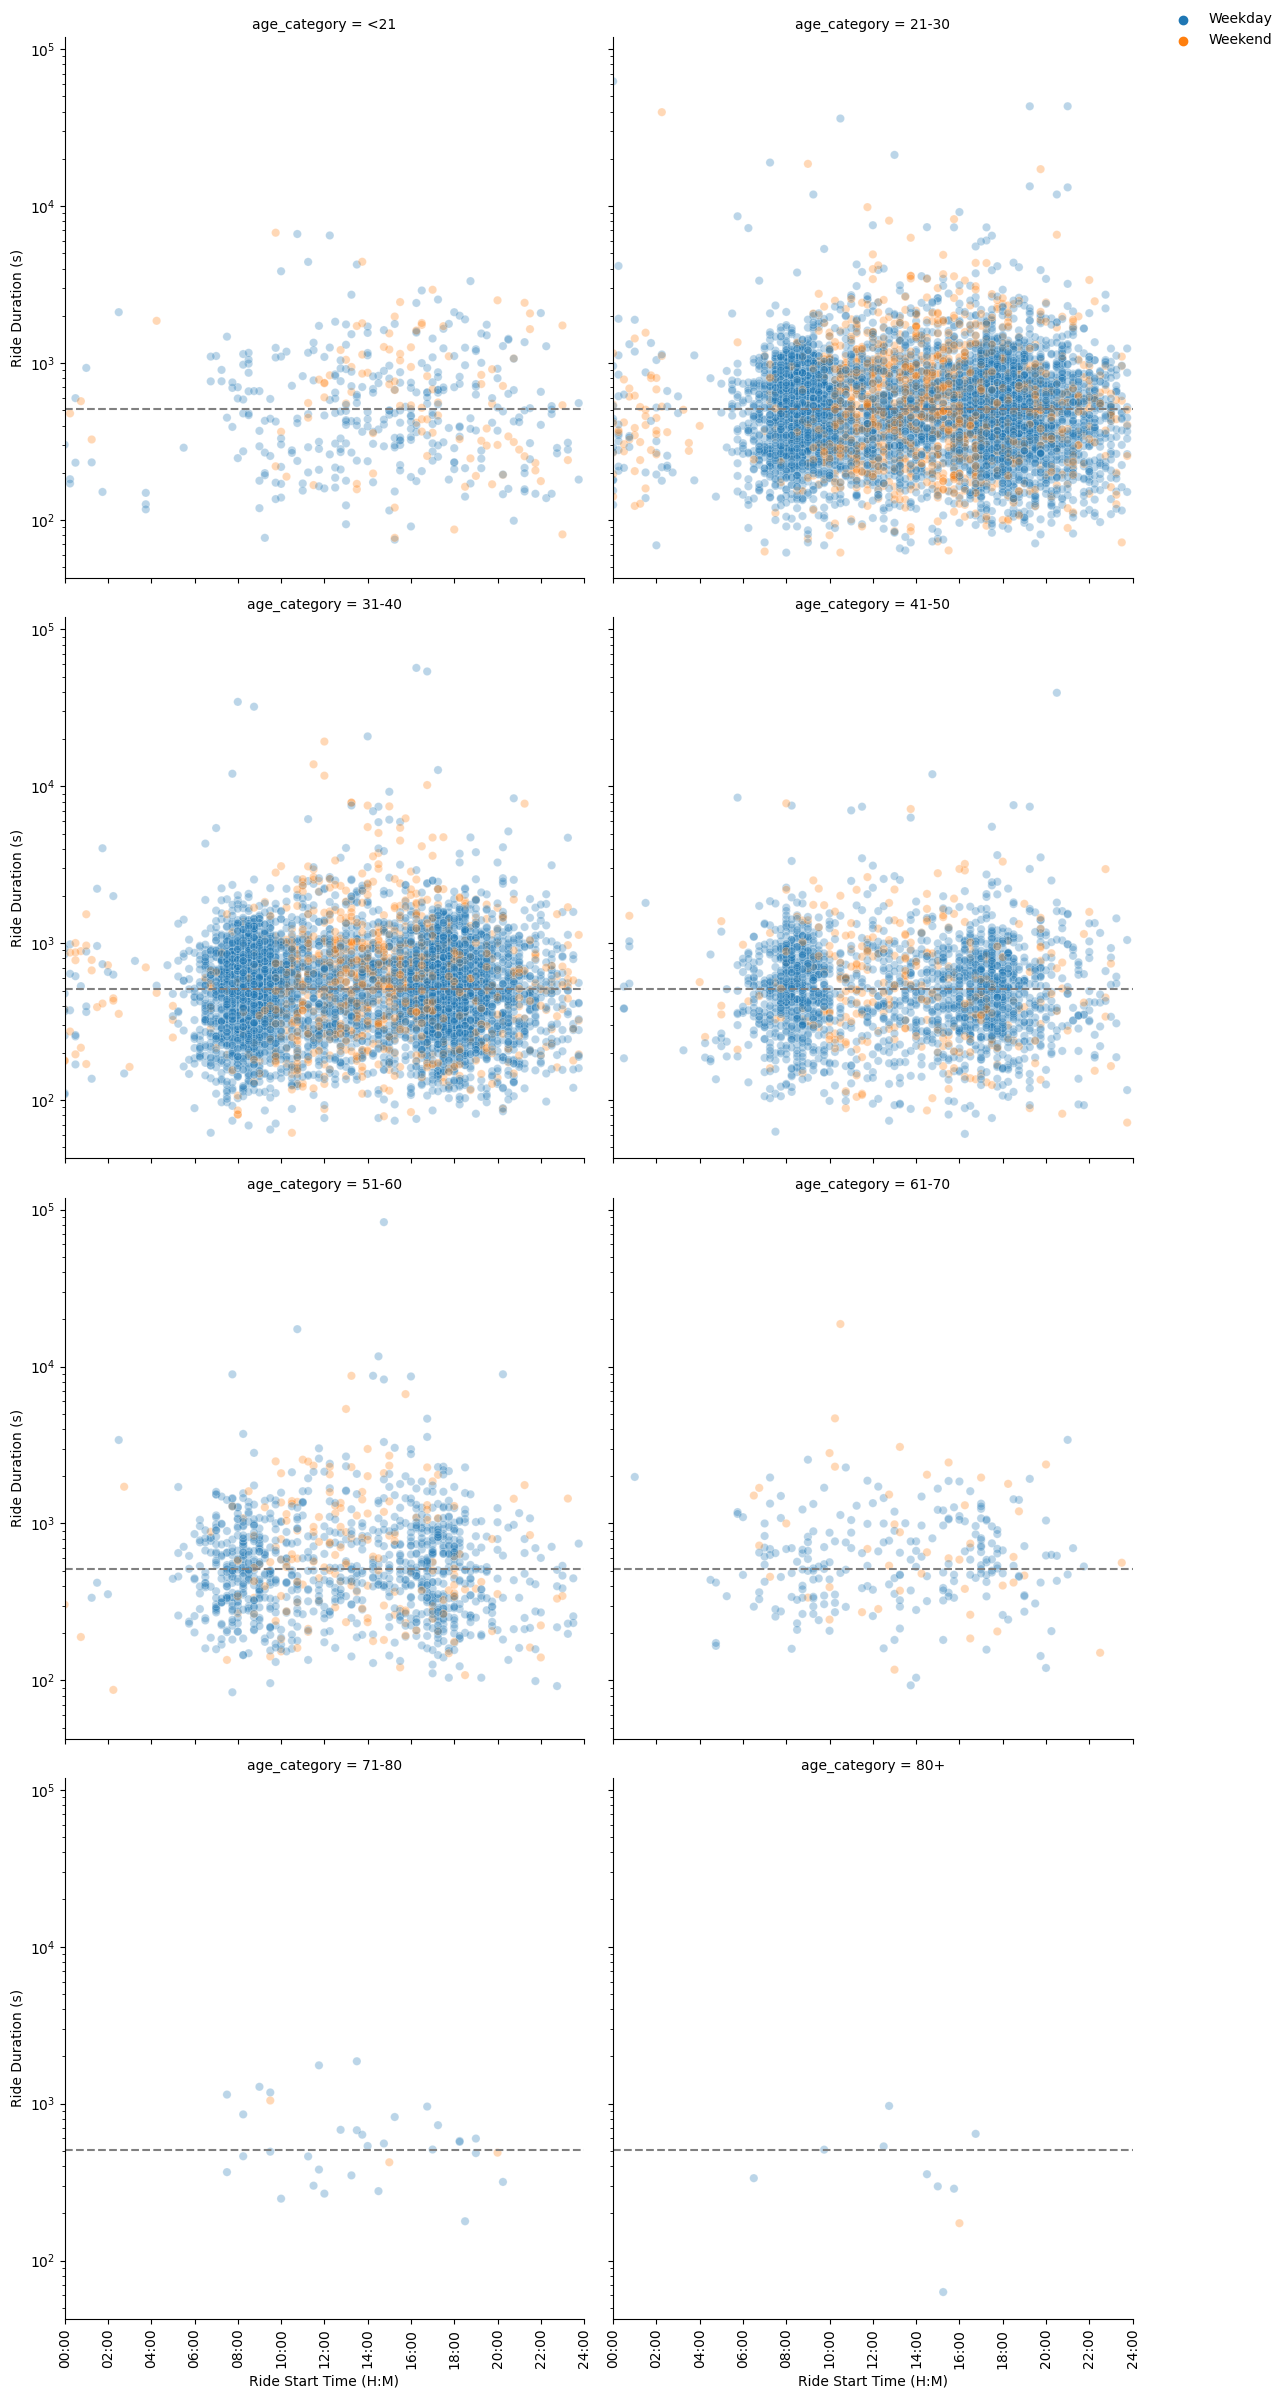

In [24]:
# Set x and y ticks for plot
xt = np.arange(0, 97, 8)
yt = [1, 10, 100, 1000, 10000, 100000]

# Create FacetGrid of Ride Start Time vs Duration vs Rider Age
g = sns.FacetGrid(data = mvar_plot_df.sample(frac = 0.10, replace = False, random_state = 21), 
                  col = 'age_category', col_wrap = 2, height = 6, aspect = 1,
                  xlim = (0, 96))
g.map_dataframe(sns.scatterplot, x = 'interval', y = 'duration_sec', hue = 'weekday_or_weekend', alpha = 0.3)
g.set(xticks = xt, yticks = yt)
g.set_axis_labels('Ride Start Time (H:M)', 'Ride Duration (s)')
g.set_xticklabels(['00:00', '02:00', '04:00', '06:00', '08:00', '10:00', '12:00', '14:00', '16:00', '18:00', '20:00', '22:00', '24:00'], rotation = 90)
g.add_legend(loc = 'upper right')
g.refline(y = 510)
plt.yscale('log');

#### Multivariate Analysis: Preliminary Observations

Multivariate analyses strengthened the earlier observations. Day of week and start time had the strongest relationship among the features. Ride duration was consistent regardless of the day of week, start time, or rider age. 

In [25]:
# Store DataFrame for Explanatory visualization
expl_plot_df = mvar_plot_df.to_csv('expl_plot_df.csv', index = False)

In [26]:
# Confirm save
expl_plot_df = pd.read_csv('expl_plot_df.csv')
expl_plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174875 entries, 0 to 174874
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   day_of_week         174875 non-null  object
 1   time_str            174875 non-null  object
 2   duration_sec        174875 non-null  int64 
 3   member_age          174875 non-null  int64 
 4   member_gender       174875 non-null  object
 5   interval            174875 non-null  int64 
 6   ride_duration       174875 non-null  object
 7   age_category        174875 non-null  object
 8   weekday_or_weekend  174875 non-null  object
dtypes: int64(3), object(6)
memory usage: 12.0+ MB


<a id='conclusions'></a>

## Conclusions

The Ford GoBike dataset contains >183,000 entries including information about ride start and end times, ride duration, rider gender and age, ride start and end location, and member status.

This analysis focuses on ride duration, ride start time, and rider gender to identify patterns in GoBike use. Key questions are: how long is the typical GoBike ride? When are the peak times for GoBikes use? Do different genders use GoBikes differently?

Key insights gained from this data set include:

*   GoBikes are used primarily for short trips (8-10 minutes)
*   Although Males make up a larger proportion of users, ride duration and weekly use patterns are similar for all genders
*   Peak weekday use coincides with typical business commute times
*   Weekend use is less than weekday use
*   Weekend use peaks mid-day and ride duration is slightly longer than weekdays


In [27]:
# Load the clean dataset into a pandas dataframe
expl_plot_df = pd.read_csv('expl_plot_df.csv')

# Set categories for Day of Week, Gender, and Weekday vs Weekend
lstdow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
catdow = pd.CategoricalDtype(ordered = True, categories = lstdow)
expl_plot_df['day_of_week'] = expl_plot_df['day_of_week'].astype(catdow)

lstg = ['Male', 'Female', 'Other']
catg = pd.CategoricalDtype(ordered = True, categories = lstg)
expl_plot_df['member_gender'] = expl_plot_df['member_gender'].astype(catg)

lst = ['Weekday', 'Weekend']
wd_we_cat = pd.CategoricalDtype(ordered = True, categories = lst)
expl_plot_df['weekday_or_weekend'] = expl_plot_df['weekday_or_weekend'].astype(wd_we_cat)

# Confirm Dtypes
expl_plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174875 entries, 0 to 174874
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   day_of_week         174875 non-null  category
 1   time_str            174875 non-null  object  
 2   duration_sec        174875 non-null  int64   
 3   member_age          174875 non-null  int64   
 4   member_gender       174875 non-null  category
 5   interval            174875 non-null  int64   
 6   ride_duration       174875 non-null  object  
 7   age_category        174875 non-null  object  
 8   weekday_or_weekend  174875 non-null  category
dtypes: category(3), int64(3), object(3)
memory usage: 8.5+ MB


## Ride Duration by Gender Type

***How long is the typical GoBike ride? Do different genders ride for different durations?***

*   The median ride duration for Males (8.2 minutes) is slightly less than that for Females (9.5 minutes) and Other (9.3 minutes)
*   The interquartile ranges for all genders have substantial overlap
*   Ride duration for all genders are not substantially different 

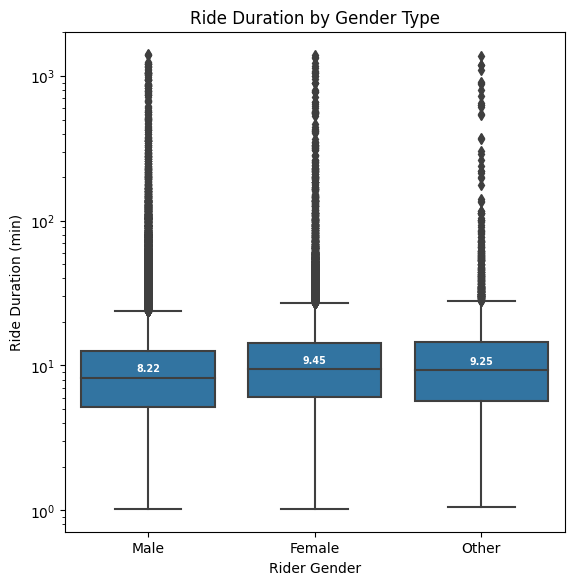

In [28]:
# Calculate ride duration in minutes
expl_plot_df['duration_min'] = expl_plot_df['duration_sec'] / 60
expl_plot_df['duration_min'] = expl_plot_df['duration_min'].round(decimals = 2)

# Generate boxplot of ride duration vs gender type
fig = plt.figure(figsize = (5, 5))
ax = fig.add_axes((1, 1, 1, 1));
ax = sns.boxplot(data = expl_plot_df, x = 'member_gender', y = 'duration_min', color = 'tab:blue')
ax.set_yscale('log')

# Label median values in minutes by adapting the method described here: https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value/38649932#38649932
medians = expl_plot_df.groupby(['member_gender']).median(numeric_only = True)
medians = medians.reset_index()
vertical_offset = expl_plot_df['duration_min'].median(numeric_only = True) * 0.1

for xtick in ax.get_xticks():
    ax.text(xtick, medians.at[xtick, 'duration_min'] + vertical_offset, medians.at[xtick, 'duration_min'], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

# Refine plot
plt.xlabel('Rider Gender')
plt.ylabel('Ride Duration (min)')
plt.title('Ride Duration by Gender Type');

# The median ride duration for Males (8.2 minutes) is slightly less than that for Females (9.5 minutes) and Other (9.3 minutes).

## Daily Rides by Day of Week and Gender Type

***When are the peak times for GoBikes use? What day of the week are GoBikes most often used? Do different genders have different daily use behavior?***

*   Although males make up a larger proportion of daily rides, each gender appears to have the same day of week riding behavior
*   Daily rides peak on Thursday and are at a minimum on weekends

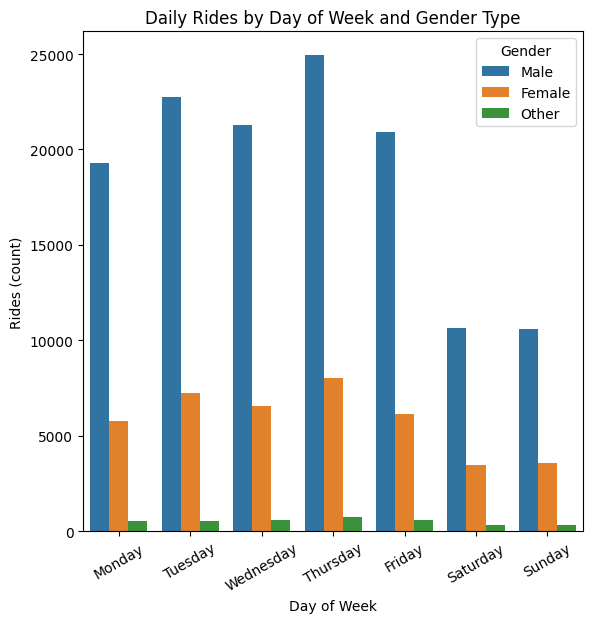

In [29]:
# Generate clustered bar chart of daily rides vs day of week and gender type
fig = plt.figure(figsize = (5, 5))
ax = fig.add_axes((1, 1, 1, 1));
ax = sns.countplot(data = expl_plot_df, x = 'day_of_week', hue = 'member_gender')
plt.xticks(rotation = 30)
plt.xlabel('Day of Week')
plt.ylabel('Rides (count)')
plt.legend(title = 'Gender')
plt.title('Daily Rides by Day of Week and Gender Type');

# Although males make up a larger proportion of daily rides, 
# each gender appears to have the same day of week riding behavior.
# Daily rides peak on Thursday and are at a minimum on weekends.

## Rides by Day of Week and Start Time

***When are the peak times for GoBikes use? What time of day are GoBikes most often used?***

*   Weekday ride start time distributions are different than weekend ride start time distributions
*   Weekday rides start at typical commute times for the workday (8-9am and 5-6pm)
*   Weekend rides start later and more uniformly throughout the day with similar density between 11am-5pm

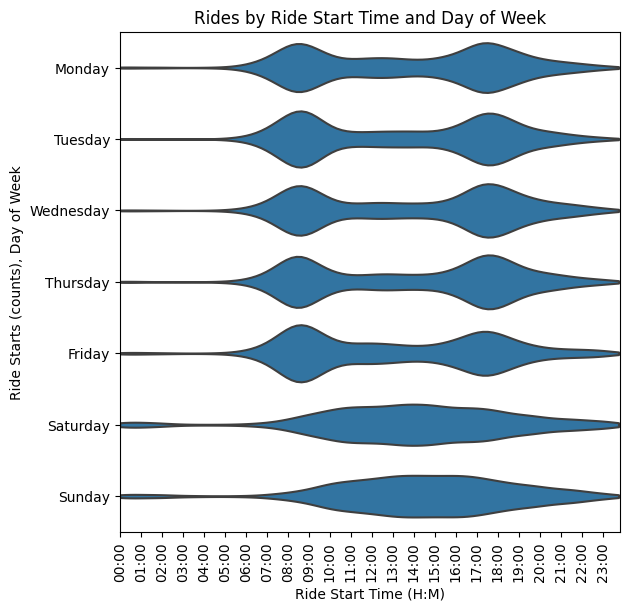

In [30]:
# Create Violin Plot of Ride Start Time vs Day of Week
fig = plt.figure(figsize = (5, 5))
ax = fig.add_axes((1, 1, 1, 1));
ax = sns.violinplot(data = expl_plot_df, x = 'interval', y = 'day_of_week', inner = None, cut = 0, color = 'tab:blue')
ax.set_xticks(np.arange(0, 96, 4), ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00',
                                   '07:00', '08:00', '09:00', '10:00', '11:00', '12:00',
                                   '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', 
                                    '19:00', '20:00', '21:00', '22:00', '23:00'])
ax.set_xlim(left = 0, right = 95.25)
plt.xticks(rotation = 90)
plt.xlabel('Ride Start Time (H:M)')
plt.ylabel('Ride Starts (counts), Day of Week')
plt.title('Rides by Ride Start Time and Day of Week');

# The weekday ride start time distribution is different than the weekend ride start time distribution.
# Weekday rides appear to start at typical commute times for the workday.
# Weekend rides appear to start later and more uniformly throughout the day.

## Ride Duration by Day of Week (weekday vs weekend) and Start Time

***Does ride duration vary by day of week? When do users take the longest rides?***

*   The longest rides start during the middle of the day (10am - 4pm)
*   The longest rides on weekends (200+ minutes) are longer than the longest rides on weekdays (100 minutes)
*   Rides on weekdays typically last between 2 - 20 minutes
*   Rides on weekends typically last between 2 - 30 minutes

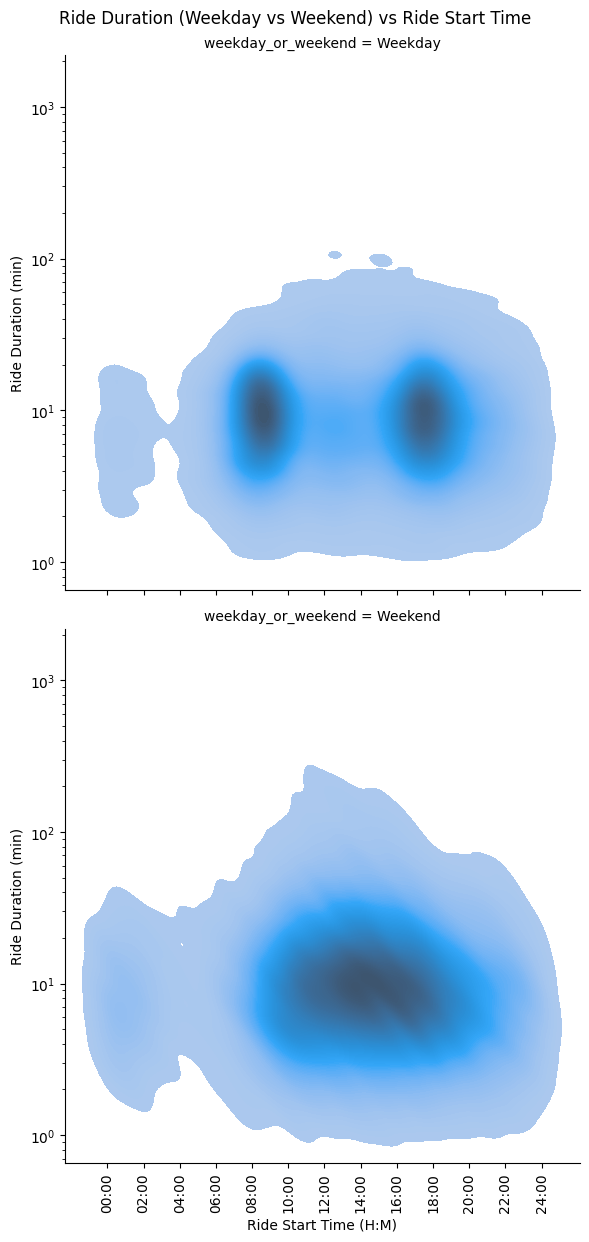

In [32]:
# Create FacetGrid of Ride Start Time vs Duration vs Weekday or Weekend
# Set x ticks
xt = np.arange(0, 97, 8)

# Plot data
g = sns.FacetGrid(data = expl_plot_df, row = 'weekday_or_weekend', height = 6, aspect = 1)
g.map_dataframe(sns.kdeplot, x = 'interval', y = 'duration_min',
                log_scale = (False, True), levels = 100, thresh = 0.01, fill = True)
g.set_axis_labels('Ride Start Time (H:M)', 'Ride Duration (min)')
g.set(xticks = xt)
g.set_xticklabels(['00:00', '02:00', '04:00', '06:00', '08:00', '10:00', '12:00', '14:00', '16:00', '18:00', '20:00', '22:00', '24:00'], rotation = 90)
plt.suptitle('Ride Duration (Weekday vs Weekend) vs Ride Start Time', y = 1.01);